First 5 rows:
    Recency  Frequency  Monetary  Time  Class
0        2         50     12500    99      1
1        0         13      3250    28      1
2        1         17      4000    36      1
3        2         20      5000    45      1
4        1         24      6000    77      0

Data Description:
           Recency   Frequency      Monetary        Time       Class
count  748.000000  748.000000    748.000000  748.000000  748.000000
mean     9.506684    5.516043   1378.676471   34.284759    0.237968
std      8.095396    5.841825   1459.826781   24.380307    0.426124
min      0.000000    1.000000    250.000000    2.000000    0.000000
25%      2.750000    2.000000    500.000000   16.000000    0.000000
50%      7.000000    4.000000   1000.000000   28.000000    0.000000
75%     14.000000    7.000000   1750.000000   50.000000    0.000000
max     74.000000   50.000000  12500.000000   99.000000    1.000000

Missing Values:
 Recency      0
Frequency    0
Monetary     0
Time         0
Class

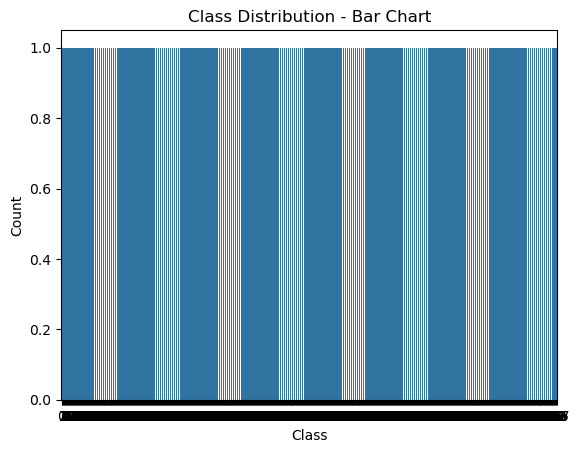

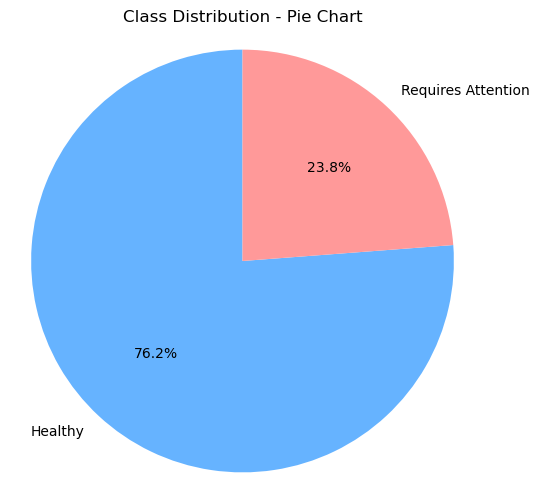


Random Forest Results:
[[91 22]
 [24 13]]
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       113
           1       0.37      0.35      0.36        37

    accuracy                           0.69       150
   macro avg       0.58      0.58      0.58       150
weighted avg       0.69      0.69      0.69       150


Logistic Regression Results:
[[110   3]
 [ 33   4]]
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       113
           1       0.57      0.11      0.18        37

    accuracy                           0.76       150
   macro avg       0.67      0.54      0.52       150
weighted avg       0.72      0.76      0.69       150


Gradient Boosting Results:
[[108   5]
 [ 29   8]]
              precision    recall  f1-score   support

           0       0.79      0.96      0.86       113
           1       0.62      0.22      0.32        37

    accuracy                       

In [14]:
# Personalized Healthcare Recommendations ML Project 
# first imporst all the libraries we need 
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

# here we willl Load the dataset
# We're currentlyyy reading the blood.csv file into a pandas DataFrame
# This dataset contains health-related features and a Class column for prediction
data = pd.read_csv('blood.csv')


# it printss out the first few rows, descriptive stats, and check for missing values using isnull 
print("First 5 rows:\n", data.head())
print("\nData Description:\n", data.describe())
print("\nMissing Values:\n", data.isnull().sum())

# im adding it by myself to Visualize the distribution of the target class with both bar and pie charts so now its more easier to understand
class_counts = data['Class'].value_counts()

# Bar chart 
sns.countplot(data['Class'])
plt.title('Class Distribution - Bar Chart')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Pie chart 
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index.map({0: 'Healthy', 1: 'Requires Attention'}),
        autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Class Distribution - Pie Chart')
plt.axis('equal')
plt.show()

# ML
# X contains features, y contains the target class
X = data.drop('Class', axis=1)
y = data['Class']

# All features are numeric in this dataset, so we scale them using StandardScaler lemme explain y-> this ensures that values like 'Recency' or 'Monetary' are on a similar scale, which helps models like logistic regression and SVM perform better 
numerical = X.columns.tolist()
categorical = []


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical)
])

# Split data for training and testing
# We'll use 80% of data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Try out different ML models and compare their results
# Each model is wrapped in a pipeline with the preprocessor
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),  # balanced handles class imbalance
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True)  # probability=True enables confidence scores
}

# Train and evaluate each modell
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"\n{name} Results:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


# This helps us find the best combination of hyperparameters
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5]
}

# Perform grid search
# i didnt explained hyperparameter above so lemme do it here for better understanding
# Hyperparameters are settings used to control how the model learns.
# - n_estimators: number of trees in the forest
# - max_depth: how deep each tree can grow (controls complexity)
# - min_samples_split: minimum number of samples needed to split a node
# These help improve the model's performance and avoid overfitting or underfitting
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print("\nBest Hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Save the trained model so it can be reused laterr use (do it )
joblib.dump(best_model, 'health_model.pkl')



# Make prediction for a new patient record and return human-friendly output
# This uses the trained model to give personalized advice based on new patient data its secure no personal information shareingg

def generate_recommendations(patient_data):
    model = joblib.load('health_model.pkl')  # Load the saved model
    prediction = model.predict(patient_data)  # Predict the class
    probability = model.predict_proba(patient_data)  # Show confidence level
    print("Prediction Confidence (Probabilities):", probability)

    recommendation_mapping = {
        0: 'Low priority / healthy',
        1: 'Requires attention'
    }
    return recommendation_mapping.get(prediction[0], 'Unknown')

# Now let’s try giving some sample health data for a new patient.
# You can play with the numbers below to simulate different cases and see what the model recommends.
example_patient_data = pd.DataFrame({
    'Recency': [2],
    'Frequency': [15],
    'Monetary': [3500],
    'Time': [48]
})

# Output the recommendation for the example patient
# This is the final step — the model gives a suggestion based on the input we just gave
print("\nPersonalized Recommendation:", generate_recommendations(example_patient_data))
